In [6]:
import datasets

imgnet = datasets.load_dataset('Maysee/tiny-imagenet', split='valid', ignore_verifications=True)
imgnet

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/datasets/load.py:2555: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(


Dataset({
    features: ['image', 'label'],
    num_rows: 10000
})

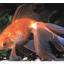

In [8]:
imgnet[0]['image']

In [9]:
imgnet[0]['image'].mode

'RGB'

In [14]:
imgnet[201]['image'].mode

'L'

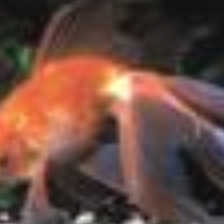

In [22]:
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224)
])
new_img = preprocess(imgnet[0]['image'])
new_img

In [25]:
import torch
from tqdm import tqdm

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
inputs = []
for img in tqdm(imgnet[:50]['image']):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    inp_tensor = preprocess(img)
    inputs.append(inp_tensor)
inputs = torch.stack(inputs)
inputs.size()

100%|██████████| 50/50 [00:00<00:00, 410.79it/s]


torch.Size([50, 3, 224, 224])

In [27]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.eval()

Using cache found in /teamspace/studios/this_studio/.cache/torch/hub/pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [28]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [30]:
inputs = inputs.to(device)
model.to(device)
with torch.no_grad():
    out = model(inputs).detach()
print(out.shape)
out

torch.Size([50, 1000])


tensor([[ 8.1108, 14.6574, -0.1506,  ...,  5.8944,  1.3372, -5.4662],
        [ 2.7997,  9.3263,  2.4853,  ..., -1.7907, -0.1574, -1.7162],
        [ 7.3128, 16.8722,  1.3526,  ...,  3.2606,  0.8557, -3.7938],
        ...,
        [ 3.5170, 10.5402, -3.2779,  ...,  1.9780,  0.7336, -1.1573],
        [ 4.2826, 13.0668,  1.2182,  ..., -1.0022,  2.9048, -5.2177],
        [ 4.0053,  8.5589, -2.4859,  ...,  2.4926,  2.2112, -2.7797]])

In [31]:
preds = torch.argmax(out, dim=1).cpu().numpy()
print(preds.shape)
preds

(50,)


array([  1,   1,   1,   1, 392,   1, 149,   1, 392,   1,   1,   1, 782,
         1, 392,  73, 392,   1,  29, 973, 392,  73, 995,   1,   1,   1,
         1, 206,   1,   1,   1,   1,   1,   1,   1,   1, 335,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1])

In [33]:
import requests
res = requests.get("https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt")

In [35]:
pred_labels = res.text.split('\n')
print(f"{len(pred_labels)}\n{pred_labels[1]}")

1000
goldfish


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


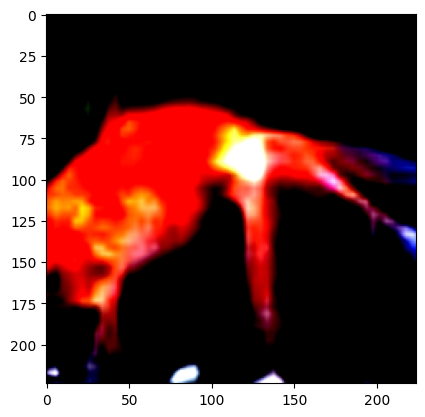

In [40]:
import matplotlib.pyplot as plt

plt.imshow(inputs[0].permute(1,2,0).detach().cpu());